<a href="https://colab.research.google.com/github/mannodiarun/MSE570/blob/main/MC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import math
import copy
import matplotlib.pyplot as plt

N = 50
x_all = [0.0]*N
y_all = [0.0]*N
box = 1

k=0
for i in range (0,int(N/5)):
    for j in range(0,int(N/10)):
        x_all[k] = np.random.rand()
        y_all[k] = np.random.rand()
#         x_all[k] = i*0.1*box
#         if math.fmod(i,2) == 0.0:
#             y_all[k] = j*0.2*box + (np.random.rand()-0.5)*0.1
# #            y_all[k] = j*0.2*box
#         else:
#             y_all[k] = j*0.2*box + 0.1 + (np.random.rand()-0.5)*0.1
# #            y_all[k] = j*0.2*box + 0.1
        k=k+1

x_start = [0.0]*N
y_start = [0.0]*N
for i in range (0,N):
    x_start[i] = x_all[i]
    y_start[i] = y_all[i]
box_start = box

kB = 1
T = 1
beta = 1/(kB*T)


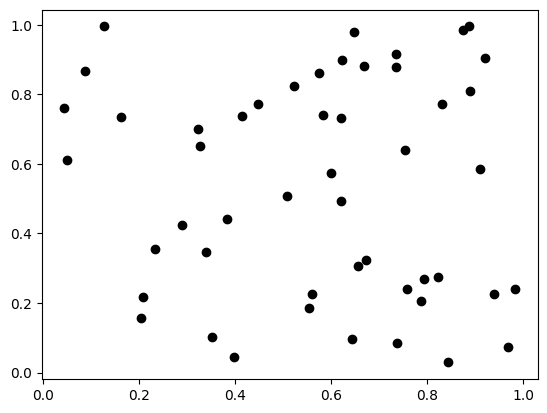

In [6]:
##  Visualize starting configuration  ##

for i in range(0,N):
    plt.scatter(x_start[i],y_start[i],c='k')
plt.show()


In [7]:
###  Use this for Simple Pairwise Potential  ##

def energy(x_all,y_all,box):

    en = 0
    c = -1/4000
    rc = 0.2
    n = len(x_all)

    for i in range (0,n-1):
        for j in range (i+1,n):
            xr = x_all[i] - x_all[j]
            xr = xr - box*np.round(xr/box)
            yr = y_all[i] - y_all[j]
            yr = yr - box*np.round(yr/box)
            r = np.sqrt(xr*xr + yr*yr)
            if r <= rc:
              en = en + c/r

    return(en)


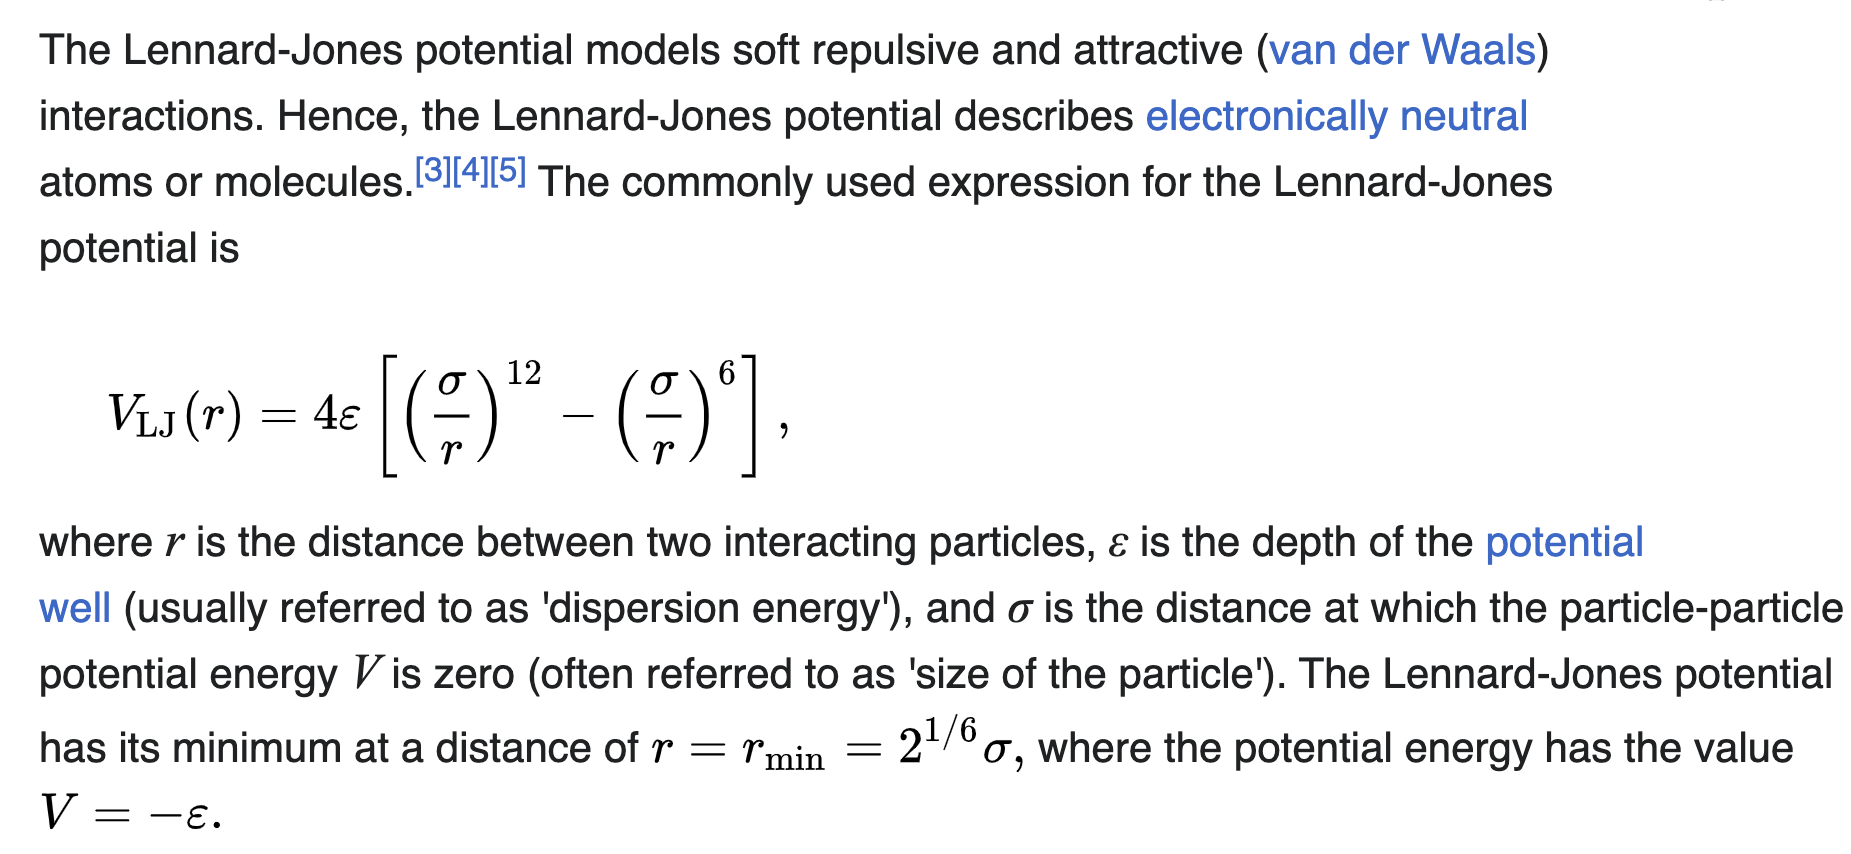

In [ ]:
###  Use this for Lennard Jones Potential  ##
###  (https://en.wikipedia.org/wiki/Lennard-Jones_potential)

def energy(x_all,y_all,box):

    en = 0
    n = len(x_all)
    forces_x = [0.0]*n
    forces_y = [0.0]*n
    rc = 0.2
    eps = 1e-42

    for i in range (0,n-1):
        for j in range (i+1,n):
            xr = x_all[i] - x_all[j]
            xr = xr - box*np.round(xr/box)
            yr = y_all[i] - y_all[j]
            yr = yr - box*np.round(yr/box)

            r2 = xr*xr + yr*yr

            if r2 <= rc*rc:
                r2i = 1/r2
                r6i = np.power(r2i,3)
                ff = 48*r2i*r6i*(r6i-0.5)
                forces_x[i] = forces_x[i] + ff*xr
                forces_x[j] = forces_x[j] - ff*xr
                forces_y[i] = forces_y[i] + ff*yr
                forces_y[j] = forces_y[j] - ff*yr
                en = (en + 4*eps*r6i*(r6i-1))

    return(en)


In [8]:
###  Use this for Calculating Average Pairwise Distances  ##

def pair_distance(x_all,y_all,box):

    k = 0
    dist_avg = 0
    n = len(x_all)

    for i in range (0,n-1):
        for j in range (i+1,n):
            xr = x_all[i] - x_all[j]
            xr = xr - box*np.round(xr/box)
            yr = y_all[i] - y_all[j]
            yr = yr - box*np.round(yr/box)
            r = np.sqrt(xr*xr + yr*yr)
            dist_avg = dist_avg + r
            k = k+1

    dist_avg = dist_avg/k

    return(dist_avg)


In [9]:
def mcmove(x_all,y_all,box):

    n = len(x_all)
    rr1 = np.random.rand()
    o = int(rr1*n)
    temp_x = x_all[o]
    temp_y = y_all[o]

    eno = energy(x_all,y_all,box)

    rr2 = np.random.rand()
    x_all[o] = x_all[o] + (rr2-0.5)*0.005*box/box_start
    y_all[o] = y_all[o] + (rr2-0.5)*0.005*box/box_start

    enn = energy(x_all,y_all,box)

    rr3 = np.random.rand()

    if ( rr3 < min(np.exp(-beta*(enn-eno)),1) ):
        eno = enn
    else:
        x_all[o] = temp_x
        y_all[o] = temp_y

    return(x_all,y_all)


In [ ]:
def mcvol(x_all,y_all,box):

    vmax = 0.01
    P = 0.000001
    n = len(x_all)

    eno = energy(x_all,y_all,box)

    rr1 = np.random.rand()
    vo = box*box
    lnvn = np.log(vo) + (rr1-0.5)*vmax
    vn = np.exp(lnvn)
    boxn = np.sqrt(vn)

    for i in range(0,n):
        x_all[i] = x_all[i]*boxn/box
        y_all[i] = y_all[i]*boxn/box

    enn = energy(x_all,y_all,boxn)

    arg = np.exp(-beta*((enn-eno) + P*(vn-vo) - (N+1)*np.log(vn/vo)/beta))

    rr2 = np.random.rand()
    if ( rr2 > arg ):
        for i in range(0,n):
            x_all[i] = x_all[i]*box/boxn
            x_all[i] = x_all[i]*box/boxn
        boxn = copy.deepcopy(box)

    return(x_all,y_all,boxn)


In [ ]:
def mcexc(x_all,y_all,box):

    mu = -0.005
    n = len(x_all)
    eno = energy(x_all,y_all,box)
    rr1 = np.random.rand()

    if rr1 < 0.5:
        rr2 = np.random.rand()
        o = int(n*rr2)
        x_temp = [0.0]*(n-1)
        y_temp = [0.0]*(n-1)
        for i in range(0,o):
            x_temp[i] = copy.deepcopy(x_all[i])
            y_temp[i] = copy.deepcopy(y_all[i])
        for i in range(o+1,n):
            x_temp[i-1] = copy.deepcopy(x_all[i])
            y_temp[i-1] = copy.deepcopy(y_all[i])
        enn = energy(x_temp,y_temp,box)
        arg = np.exp(beta*(eno-enn-mu))
        rr3 = np.random.rand()
        if rr3 < arg:
            x_all = copy.deepcopy(x_temp)
            y_all = copy.deepcopy(y_temp)

    else:
        x_temp = [0.0]*(n+1)
        y_temp = [0.0]*(n+1)
        for i in range(0,n):
            x_temp[i] = copy.deepcopy(x_all[i])
            y_temp[i] = copy.deepcopy(y_all[i])
        rr2 = np.random.rand()
        rr3 = np.random.rand()
        x_temp[n] = rr2*box
        y_temp[n] = rr3*box
        enn = energy(x_temp,y_temp,box)
        arg = np.exp(beta*(eno-enn+mu))
        rr4 = np.random.rand()
        if rr4 < arg:
            x_all = copy.deepcopy(x_temp)
            y_all = copy.deepcopy(y_temp)

    return(x_all,y_all)


In [10]:
def sample(k,x,y,box):

    return(k, pair_distance(x,y,box), energy(x,y,box))


In [21]:
def mc(x_start,y_start,box_start,ncycl,nsamp):

    k = 0
    x = copy.deepcopy(x_start)
    y = copy.deepcopy(y_start)
    box = box_start
    cycles = [0]*int(ncycl/nsamp)
    energies = [0]*int(ncycl/nsamp)
    pair_distances = [0]*int(ncycl/nsamp)
    expt_pd = 0.0
    part_func = 0.0

    for icycl in range(0,ncycl):

        if math.fmod(icycl, nsamp) == 0.0:
            k = int(icycl/nsamp)
            cyc, dist, en = sample(k,x,y,box)
            cycles[k] = cyc*nsamp
            energies[k] = en
            pair_distances[k] = dist
            expt_pd = expt_pd + dist*en
            part_func = part_func + en

        x,y = mcmove(x,y,box)

#        rr = np.random.rand()
#        if rr < 0.9:
#            x,y = mcmove(x,y,box)
#        else:
#            x,y,box = mcvol(x,y,box)
#            x,y = mcexc(x,y,box)
            # if len(x) > 0:
            #     x,y = mcexc(x,y,box)
            # else:
            #     x = copy.deepcopy(x_start)
            #     y = copy.deepcopy(y_start)

#    plt.plot(cycles[:], energies[:])
    plt.plot(cycles[:], pair_distances[:], c= 'b')

    return(x,y,box,expt_pd/part_func,cycles,energies,pair_distances)


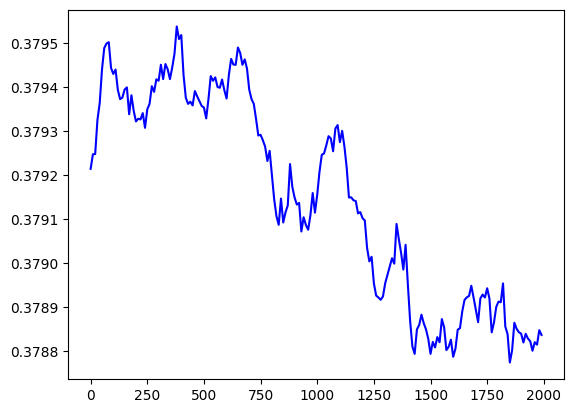

In [22]:
## Example run involving mcmove and mcvol ##

ncycl = 2000
nsamp = 10

x_final, y_final, box_final, pair_dist_expectation_value, cycles, energies, pair_distances = mc(x_start,y_start,box_start,ncycl,nsamp)


In [23]:
pair_dist_expectation_value

0.37915392275208526

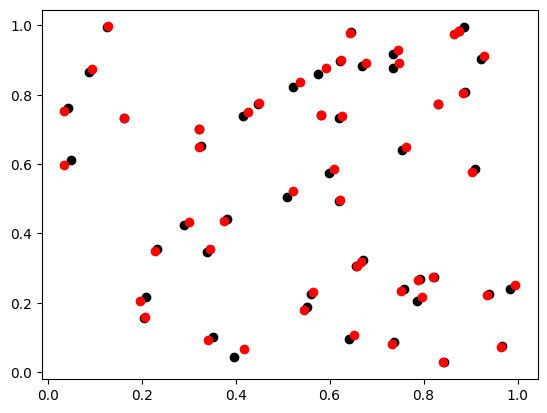

In [17]:
for i in range(0,N):
    plt.scatter(x_start[i],y_start[i],c='k')
for i in range(0,len(x_final)):
   plt.scatter(x_final[i],y_final[i],c='r')
plt.show()


In [19]:
box_final

1

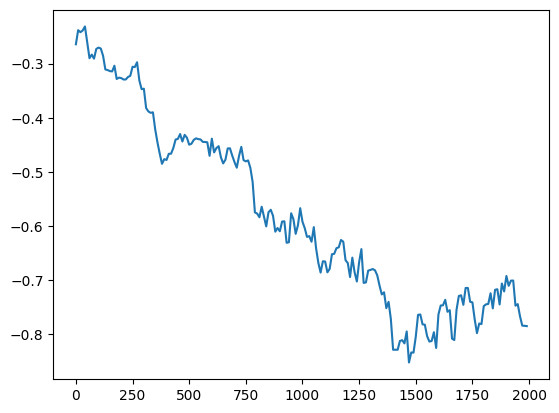

In [ ]:
## Example run involving mcmove and mcexc ##

ncycl = 2000
nsamp = 10

x_final,y_final,box_final = mc(x_start,y_start,box_start,ncycl,nsamp)


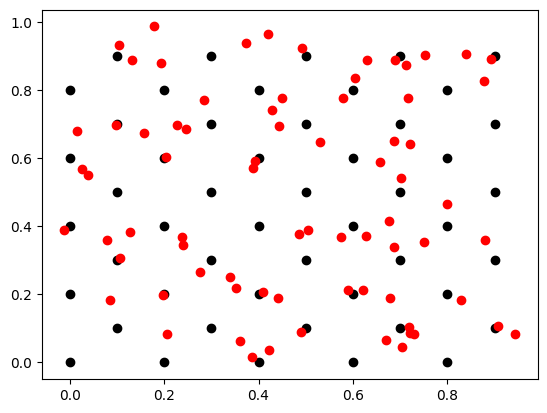

In [ ]:
for i in range(0,N):
    plt.scatter(x_start[i],y_start[i],c='k')
for i in range(0,len(x_final)):
   plt.scatter(x_final[i],y_final[i],c='r')
plt.show()


In [ ]:
len(y_final)

74